# Road Accident Severity Classification and Prediction

# Importing the required libraries

In [147]:
#Importing the required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer,VectorAssembler,OneHotEncoder
from pyspark.sql.functions import col,count,isnan,when
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [148]:
spark = SparkSession \
    .builder \
    .appName("Road accident Prediction and classification") \
    .getOrCreate()
#https://www.nbshare.io/notebook/187478734/How-To-Read-CSV-File-Using-Python-PySpark/

In [149]:
#Representing the spark version
spark.version

'3.2.1'

# Reading the Dataset

In [150]:
#Reading the dataset using pyspark
#https://www.nbshare.io/notebook/187478734/How-To-Read-CSV-File-Using-Python-PySpark/
df_road=spark.read.format("csv").option("header","true").load("/Users/prathima/Downloads/RTA Dataset.csv")


In [151]:
#https://stackoverflow.com/questions/39067505/pyspark-display-a-spark-data-frame-in-a-table-format
df_road.show(vertical=True)
#Displaying the dataset  using spark

-RECORD 0-------------------------------------------
 Time                        | 17:02:00             
 Day_of_week                 | Monday               
 Age_band_of_driver          | 18-30                
 Sex_of_driver               | Male                 
 Educational_level           | Above high school    
 Vehicle_driver_relation     | Employee             
 Driving_experience          | 1-2yr                
 Type_of_vehicle             | Automobile           
 Owner_of_vehicle            | Owner                
 Service_year_of_vehicle     | Above 10yr           
 Defect_of_vehicle           | No defect            
 Area_accident_occured       | Residential areas    
 Lanes_or_Medians            | null                 
 Road_allignment             | Tangent road with... 
 Types_of_Junction           | No junction          
 Road_surface_type           | Asphalt roads        
 Road_surface_conditions     | Dry                  
 Light_conditions            | Daylight       

# Selecting the particular columns from the dataset 

In [152]:
#Selecting the particulr columns from the given dataset as below.
columns_selected=['Age_band_of_driver',
 'Sex_of_driver',
 'Educational_level',
 'Vehicle_driver_relation',
 'Driving_experience',
 'Lanes_or_Medians',
 'Types_of_Junction',
 'Road_surface_type',
 'Light_conditions',
 'Weather_conditions',
 'Type_of_collision',
 'Vehicle_movement',
 'Pedestrian_movement',
 'Cause_of_accident',
 'Accident_severity']

In [153]:
#creating the dataframe using that columns we have selected below and displaying the selected data
road_data=df_road.select(*columns_selected)
road_data.show(vertical=True)


-RECORD 0---------------------------------------
 Age_band_of_driver      | 18-30                
 Sex_of_driver           | Male                 
 Educational_level       | Above high school    
 Vehicle_driver_relation | Employee             
 Driving_experience      | 1-2yr                
 Lanes_or_Medians        | null                 
 Types_of_Junction       | No junction          
 Road_surface_type       | Asphalt roads        
 Light_conditions        | Daylight             
 Weather_conditions      | Normal               
 Type_of_collision       | Collision with ro... 
 Vehicle_movement        | Going straight       
 Pedestrian_movement     | Not a Pedestrian     
 Cause_of_accident       | Moving Backward      
 Accident_severity       | Slight Injury        
-RECORD 1---------------------------------------
 Age_band_of_driver      | 31-50                
 Sex_of_driver           | Male                 
 Educational_level       | Junior high school   
 Vehicle_driver_rela

# Checking for the Null Values and Dropping them

In [154]:
#https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/#:~:text=In%20PySpark%20DataFrame%20you%20can,count()%20and%20when().
#Checking for the null values in the dataset using select method from pyspark
road_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in road_data.columns]
   ).show(vertical=True)

-RECORD 0----------------------
 Age_band_of_driver      | 0   
 Sex_of_driver           | 0   
 Educational_level       | 741 
 Vehicle_driver_relation | 579 
 Driving_experience      | 829 
 Lanes_or_Medians        | 385 
 Types_of_Junction       | 887 
 Road_surface_type       | 172 
 Light_conditions        | 0   
 Weather_conditions      | 0   
 Type_of_collision       | 155 
 Vehicle_movement        | 308 
 Pedestrian_movement     | 0   
 Cause_of_accident       | 0   
 Accident_severity       | 0   



In [155]:
#Dropping all the null values using the dropna() function
#https://sparkbyexamples.com/pyspark/pyspark-drop-rows-with-null-values/#:~:text=By%20using%20the%20drop(),result%20in%20NULL%20on%20DataFrame.
road_data=road_data.dropna()

In [156]:
#Displaaying the removal of null values
#https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/?expand_article=1
road_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in road_data.columns]
   ).show(vertical=True)

-RECORD 0----------------------
 Age_band_of_driver      | 0   
 Sex_of_driver           | 0   
 Educational_level       | 0   
 Vehicle_driver_relation | 0   
 Driving_experience      | 0   
 Lanes_or_Medians        | 0   
 Types_of_Junction       | 0   
 Road_surface_type       | 0   
 Light_conditions        | 0   
 Weather_conditions      | 0   
 Type_of_collision       | 0   
 Vehicle_movement        | 0   
 Pedestrian_movement     | 0   
 Cause_of_accident       | 0   
 Accident_severity       | 0   



In [157]:
#Describing the datatype of the coliumns
road_data.printSchema()
#https://www.analyticsvidhya.com/blog/2022/04/data-preprocessing-using-pysparks-dataframe/

root
 |-- Age_band_of_driver: string (nullable = true)
 |-- Sex_of_driver: string (nullable = true)
 |-- Educational_level: string (nullable = true)
 |-- Vehicle_driver_relation: string (nullable = true)
 |-- Driving_experience: string (nullable = true)
 |-- Lanes_or_Medians: string (nullable = true)
 |-- Types_of_Junction: string (nullable = true)
 |-- Road_surface_type: string (nullable = true)
 |-- Light_conditions: string (nullable = true)
 |-- Weather_conditions: string (nullable = true)
 |-- Type_of_collision: string (nullable = true)
 |-- Vehicle_movement: string (nullable = true)
 |-- Pedestrian_movement: string (nullable = true)
 |-- Cause_of_accident: string (nullable = true)
 |-- Accident_severity: string (nullable = true)



# Converting the Categorial columns into numerical one:

In [158]:
cat_columns=['Age_band_of_driver',
 'Sex_of_driver',
 'Educational_level',
 'Vehicle_driver_relation',
 'Driving_experience',
 'Lanes_or_Medians',
 'Types_of_Junction',
 'Road_surface_type',
 'Light_conditions',
 'Weather_conditions',
 'Type_of_collision',
 'Vehicle_movement',
 'Pedestrian_movement',
 'Cause_of_accident',
 'Accident_severity']

In [159]:
# Apply the StringIndexer stages to the DataFrame
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
            for col in cat_columns]

indexed_data=road_data
for indexer in indexers:
    indexed_data = indexer.fit(indexed_data).transform(indexed_data)


In [160]:
indexed_data = indexed_data.drop(*cat_columns)


In [161]:

indexed_data.show()

+------------------------+-------------------+-----------------------+-----------------------------+------------------------+----------------------+-----------------------+-----------------------+----------------------+------------------------+-----------------------+----------------------+-------------------------+-----------------------+-----------------------+
|Age_band_of_driver_index|Sex_of_driver_index|Educational_level_index|Vehicle_driver_relation_index|Driving_experience_index|Lanes_or_Medians_index|Types_of_Junction_index|Road_surface_type_index|Light_conditions_index|Weather_conditions_index|Type_of_collision_index|Vehicle_movement_index|Pedestrian_movement_index|Cause_of_accident_index|Accident_severity_index|
+------------------------+-------------------+-----------------------+-----------------------------+------------------------+----------------------+-----------------------+-----------------------+----------------------+------------------------+-----------------------+

# Exploratory Data Analysis

In [162]:
#converting the pyspark dataframe to pandas dataframe for data analysis
#https://sparkbyexamples.com/pandas/convert-pyspark-dataframe-to-pandas/#:~:text=Convert%20PySpark%20Dataframe%20to%20Pandas%20DataFrame,small%20subset%20of%20the%20data.
data2=indexed_data.toPandas()


In [163]:
#Displaying the pandas dataframe of the given dataset
data2

,Age_band_of_driver_index,Sex_of_driver_index,Educational_level_index,Vehicle_driver_relation_index,Driving_experience_index,Lanes_or_Medians_index,Types_of_Junction_index,Road_surface_type_index,Light_conditions_index,Weather_conditions_index,Type_of_collision_index,Vehicle_movement_index,Pedestrian_movement_index,Cause_of_accident_index,Accident_severity_index
0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
1,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0
4,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9582,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,10.0,0.0
9583,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
9584,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
9585,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,9.0,0.0


In [164]:
#Displaying the description of the each column in the dataset
#https://www.w3schools.com/python/pandas/ref_df_describe.asp#:~:text=The%20describe()%20method%20returns,std%20%2D%20The%20standard%20deviation.
data2.describe()

,Age_band_of_driver_index,Sex_of_driver_index,Educational_level_index,Vehicle_driver_relation_index,Driving_experience_index,Lanes_or_Medians_index,Types_of_Junction_index,Road_surface_type_index,Light_conditions_index,Weather_conditions_index,Type_of_collision_index,Vehicle_movement_index,Pedestrian_movement_index,Cause_of_accident_index,Accident_severity_index
count,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000
mean,1.246062,0.086784,0.600396,0.177219,1.607176,1.228747,1.009388,0.131741,0.310107,0.373005,0.520497,1.037134,0.177636,3.786482,0.161573
std,1.238363,0.331872,1.040196,0.407767,1.400002,1.326964,1.141335,0.553483,0.509973,1.024534,1.059601,1.985782,0.740788,3.626926,0.398296
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,2.000000,0.000000,1.000000,0.000000,3.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,5.000000,0.000000
max,4.000000,2.000000,6.000000,3.000000,6.000000,6.000000,7.000000,4.000000,3.000000,8.000000,9.000000,12.000000,8.000000,19.000000,2.000000


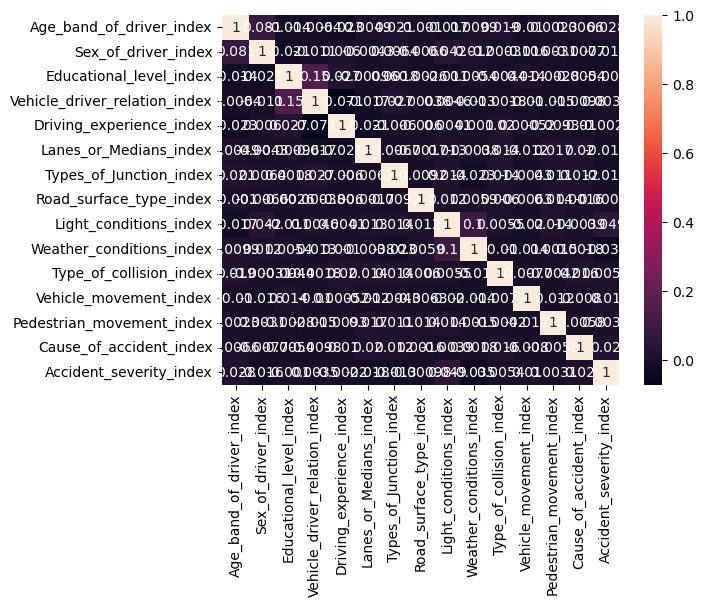

In [165]:
#Disolaying the correalation between features in the dataset
sns.heatmap(data2.corr(),annot=True)
plt.show()

In [166]:
#Selecting the features from the dataset for data analysis
categorical_features=['Age_band_of_driver_index',
 'Sex_of_driver_index',
 'Educational_level_index',
 'Vehicle_driver_relation_index',
 'Driving_experience_index',
 'Lanes_or_Medians_index',
 'Types_of_Junction_index',
 'Road_surface_type_index',
 'Light_conditions_index',
 'Weather_conditions_index',
 'Type_of_collision_index',
 'Vehicle_movement_index',
 'Pedestrian_movement_index',
 'Cause_of_accident_index']

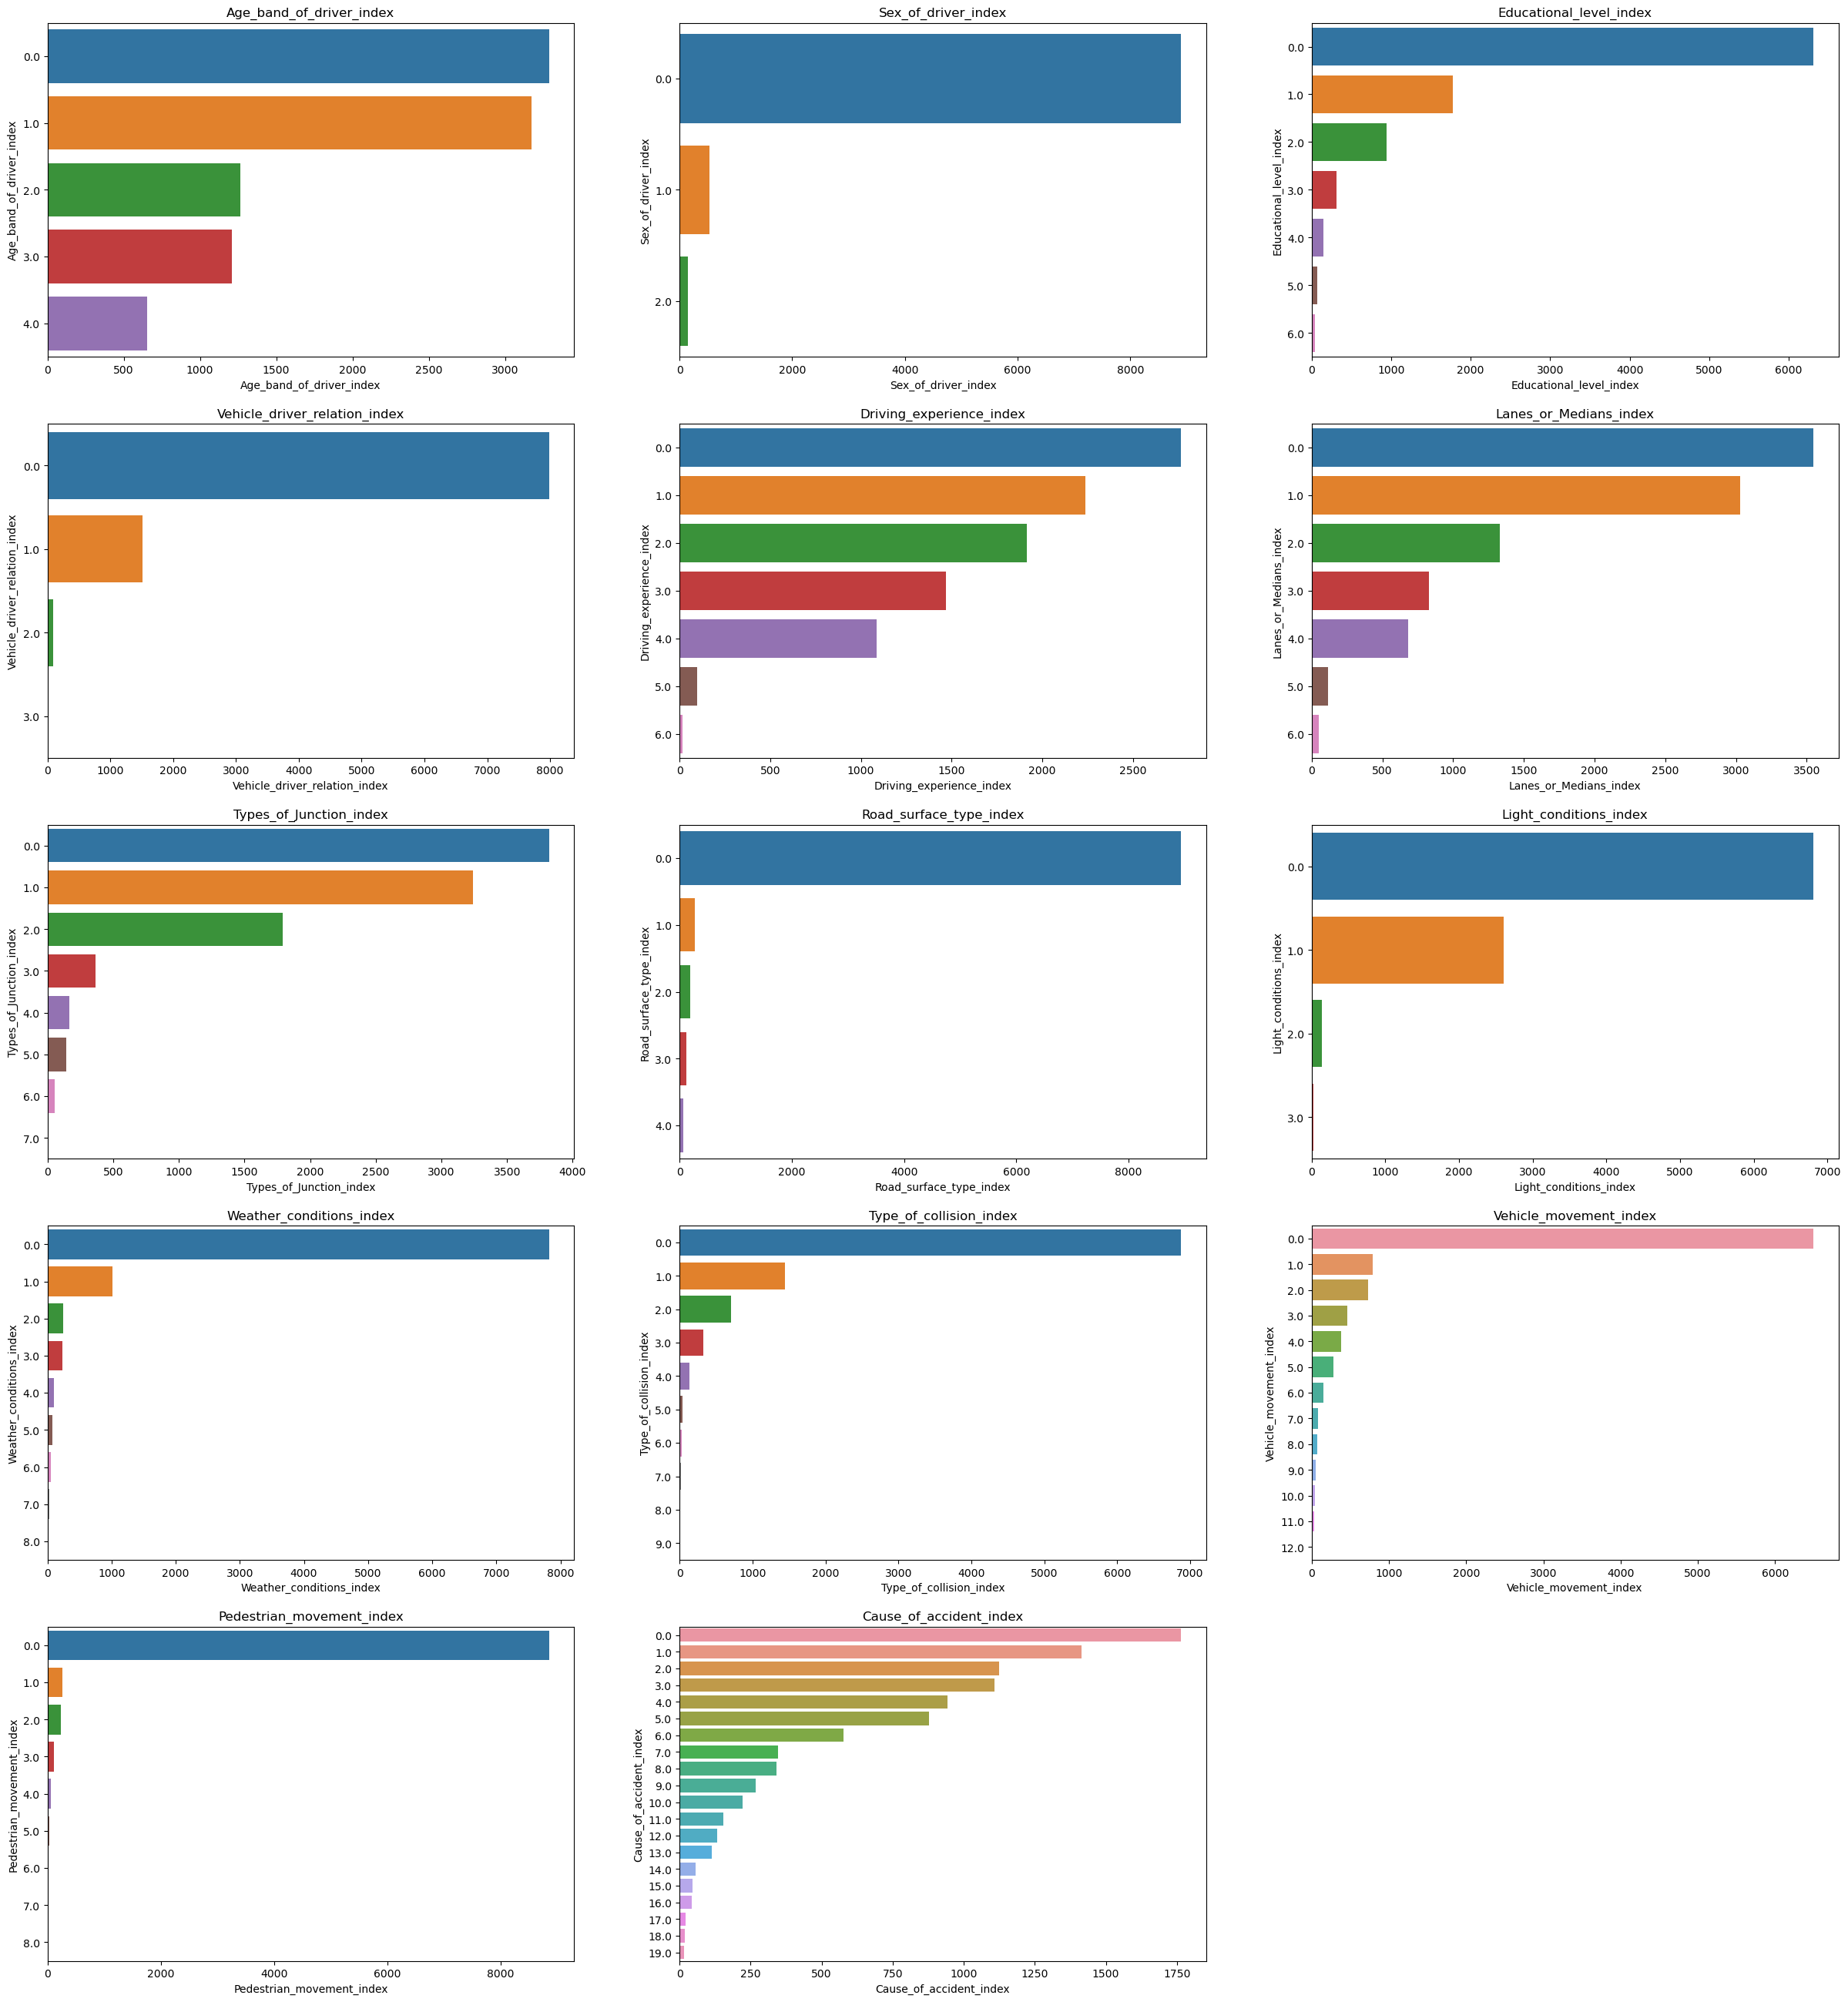

In [167]:
#Displaying the counterplot for the features present in the dataset using seaborn library of pandas
plt.figure(figsize=(30,80), facecolor='white')
plotnumber = 1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=data2)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

# Creating the  Vector assembler 

In [168]:
#Selecting the features from the dataset
feat_columns=['Age_band_of_driver_index',
 'Sex_of_driver_index',
 'Educational_level_index',
 'Vehicle_driver_relation_index',
 'Driving_experience_index',
 'Lanes_or_Medians_index',
 'Types_of_Junction_index',
 'Road_surface_type_index',
 'Light_conditions_index',
 'Weather_conditions_index',
 'Type_of_collision_index',
 'Vehicle_movement_index',
 'Pedestrian_movement_index',
 'Cause_of_accident_index',
 ]

In [169]:
#creating an assembler using the VectorAssembler method
assembler = VectorAssembler(inputCols=feat_columns, outputCol="features")

In [170]:
#dividing the dataset into training data and testing data
train_data, test_data = indexed_data.randomSplit([0.8, 0.2], seed=42)

In [171]:
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# CLASSIFICATION  ALGORITHMS

# RandomForestClassifier

In [172]:
#https://towardsdatascience.com/a-guide-to-exploit-random-forest-classifier-in-pyspark-46d6999cb5db
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
rf=RandomForestClassifier(featuresCol="features", labelCol="Accident_severity_index",numTrees=50, maxDepth=10)
rf_Model = rf.fit(train_data)
predictions_rf = rf_Model.transform(test_data)
#predictions_rf.collect()
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_rf_model = MulticlassClassificationEvaluator(labelCol="Accident_severity_index",predictionCol="prediction")
accuracy_rf = evaluator_rf_model.evaluate(predictions_rf)*100
print("Accuracy = %s" % accuracy_rf)




23/07/25 21:15:09 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
23/07/25 21:15:10 WARN DAGScheduler: Broadcasting large task binary with size 1525.5 KiB
23/07/25 21:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/07/25 21:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/07/25 21:15:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Accuracy = 78.96594683672758


# Logistic Regression

In [173]:
#https://www.geeksforgeeks.org/logistic-regression-using-pyspark-python/
from pyspark.ml.classification import LogisticRegression
lg= LogisticRegression(featuresCol="features", labelCol="Accident_severity_index",maxIter=1000, regParam=0.01, elasticNetParam=0.8,family="multinomial")
lgModel = lg.fit(train_data)
prediction_log = lgModel.transform(test_data)
evaluator_log = MulticlassClassificationEvaluator(labelCol="Accident_severity_index",predictionCol="prediction")
accuracy_log = evaluator_log.evaluate(prediction_log)*100
print("Accuracy = %s" % accuracy_log)

Accuracy = 78.83480286427208


# DecisionTree Classifier

In [174]:
#https://www.machinelearningplus.com/pyspark/pyspark-decision-tree/
from pyspark.ml.classification import DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(featuresCol ='features', labelCol = 'Accident_severity_index')
dtree_model = decision_tree_classifier.fit(train_data)
dtree_predictions = dtree_model.transform(test_data)
#dtree_predictions.collect()
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_dtree = MulticlassClassificationEvaluator(labelCol="Accident_severity_index", predictionCol="prediction")
accuracy_dtree = evaluator_dtree.evaluate(dtree_predictions)*100
print("Accuracy = %s" % accuracy_dtree)


Accuracy = 79.09606933104133


# REGRESSION  ALGORITHMS

# Random Forest Regressor

In [175]:
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html
model = RandomForestRegressor(featuresCol="features", labelCol="Accident_severity_index")  # Replace with the appropriate algorithm and parameters

# Create a pipeline
pipeline = Pipeline(stages=[model])

# Fit the model
pipeline_model = pipeline.fit(train_data)

# Make predictions
predictions_rf_reg = pipeline_model.transform(test_data)

# Evaluate the model
evaluator_rf_reg = RegressionEvaluator(labelCol="Accident_severity_index", metricName="rmse")  # Replace with the appropriate evaluator and metric
rmse_rf = evaluator_rf_reg.evaluate(predictions_rf_reg)

# Print the evaluation metric
print("Root Mean Squared Error (RMSE):", rmse_rf)

Root Mean Squared Error (RMSE): 0.393465961307092


# Decision Tree Regressor

In [176]:
#ttps://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.DecisionTreeRegressor.html
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Accident_severity_index')
dt_reg_model = dt.fit(train_data)
dt_reg_predictions = dt_reg_model.transform(test_data)
dt_reg_evaluator = RegressionEvaluator(
    labelCol="Accident_severity_index", predictionCol="prediction", metricName="rmse")
rmse_dt = dt_reg_evaluator.evaluate(dt_reg_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_dt)

Root Mean Squared Error (RMSE) on test data = 0.39763
